# Linear Least Squares
This notebook discusses and explains how to use the linear least squares function, `LS`, and the linear least squares class, `LsClass`, available from the TFC utilities. They are used regularly in the context of TFC when minimizing the residual of differential equations, but are written in a general way so that they can be applied to any problem that requires linear least-squares.

The `LS` function and `LsClass` can utilize automatic differentiation, so the user need only supply the residual function. Moreover, both are designed to work with unkowns given as an array, a `TFCDict`, or a `TFCRobustDict`; the latter two options in particular are extremely useful when one has multiple arrays of unkowns such as in systems of ODEs or PDEs. Moreover, both `LS` and `LsClass` JIT the entire linear least-squares process, and provide the option to calculate the run-time of the compiled code. 

## `LS` Function
The LS function is designed for cases where the linear least-squares needs to be run only once. 

### Positional input arguments
This function function takes in two required positional arguments and one optional position argument. The two required positional arguments are the unknowns, filled with zeros, and the residual function: the residual function must be structured such that the unkowns are the first argument. The one optional position argument is \*args, which is used if the residual function has more arguments than the unknowns. In other words, the residual function should be of the form, $\mathbb{L}(\xi,*args)$, where $\mathbb{L}$ is the residual function, $\xi$ are the unknowns, and \*args are any additional arguments.

### Optional input keyword arguments
The optional keyword arguments to the `LS` function are:

* $\mathcal{J}$ - User-specified Jacobian. The default option is to compute the Jacobian of $\mathbb{L}$ with respect to $\xi$ using the automatic differentiation 
* timer - Setting this to True will time the linear least squares using the timer specified by timerType. The default is False.
* timerType - The timer from the timer package that will be used to time the code. The default is [process_time](https://docs.python.org/3/library/time.html).
* method - Method used to invert the matrix at each iteration. The default is pinv. The two options are:
  * pinv - Uses [Numpy's pinv](https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html) to perform the inversion.
  * lstsq - Uses [Numpy's lstsq](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html) to perform the inversion.

### Outputs
The outputs of the function are:

* $\xi$ - The value of $\xi$ at the end of the linear least squares.
* time - If the keyword argument timer = True, then the second output is the time the linear least-squares took; otherwise, there is no second output.

As a demonstrative example, suppose one wanted to approximate the function $y = a e^{b x}$ using a linear expansion of Chebyshev polynomials. Let the coefficients in that expansion be $\xi$. 

LS run time: 0.000864521000000007 seconds.
Maximum error: 4.440892098500626e-15


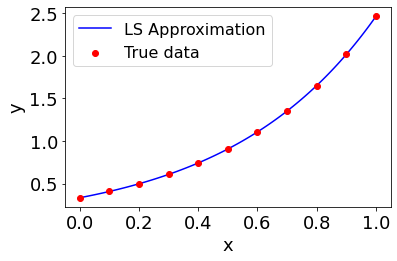

In [1]:
import jax.numpy as np
from tfc.utils import BF, LS, MakePlot

# This line is added for Python notebooks but is not necessary in a regular Python script.
%matplotlib inline 

# Create the true data
a = 1/3
b = 2
x = np.linspace(0,1,101)
y = a*np.exp(b*x)

# Create the Chebyshev polynomials
cp = BF.CP(0.,1.,np.array([-1],dtype=np.int32),20)
H = cp.H(x,0,True)

# Create the approximating function
g = lambda xi: np.dot(H,xi)

# Create the residual function
L = lambda xi: g(xi)-y

# Solve for the unknowns using LS
xi0 = np.zeros(H.shape[1])
xi,time = LS(xi0,L,timer=True)

# Plot and print results
p = MakePlot('x','y')
p.ax[0].scatter(x[::10],y[::10],color='r',label='True data',zorder=3)
p.ax[0].plot(x,g(xi),'b-',label='LS Approximation')
p.ax[0].legend()
p.show()

print("LS run time: "+str(time)+" seconds.")
print("Maximum error: "+str(np.max(np.abs(L(xi)))))

As one can see, parameters $\xi$ were found in a matter of milliseconds that minimize the loss function. As mentioned earlier, this can be done not just for arrays of unkowns, but `TFCDict`s and `TFCRobustDict`s as well. In addition, the loss functions can take extra arguments other than the unknown parameters. For example, suppose we have a dictionary of unknowns used in our approximating function $g$, and that $g$ also takes in some other arguments.

LS run time: 0.002220807000000047 seconds.
Maximum error: 4.163336342344337e-15


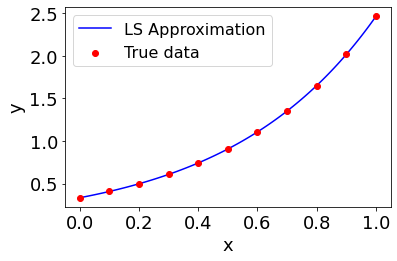

In [2]:
from tfc.utils import TFCDict

# Create the approximating function
g = lambda xi,c1,c2: c1*np.dot(H,xi['xi1'])+c2*np.dot(H,xi['xi2'])

# Create the residual function
c1 = 2.
c2 = 1.
L = lambda xi,c1,c2: g(xi,c1,c2)-y

# Solve for the unknowns using LS
xi = TFCDict({'xi1':np.zeros(H.shape[1]),
              'xi2':np.zeros(H.shape[1])})
xi,time = LS(xi,L,c1,c2,timer=True)

# Plot and print results
p = MakePlot('x','y')
p.ax[0].scatter(x[::10],y[::10],color='r',label='True data',zorder=3)
p.ax[0].plot(x,g(xi,c1,c2),'b-',label='LS Approximation')
p.ax[0].legend()
p.show()

print("LS run time: "+str(time)+" seconds.")
print("Maximum error: "+str(np.max(np.abs(L(xi,c1,c2)))))

Once again, $\xi$ parameters that minimize the residual function are found in a matter of milliseconds. 

## Linear least-squares class (`LsClass`)
The `LsClass` is designed to be used when the linear least-squares must be called multiple times. The class saves the JIT-ed linear least-squares function which can be called via the run method, whereas the `LS` function just runs it once. The `LsClass` is initialized in the same way the `LS` function is, except the \*args positional argument is eliminated; The \*args argument is only used when calling the run method. The run method only takes in the two position arguments $\xi$ and \*args, and the outputs are the same as the `LS` [outputs](#Outputs). To demonstrate, consider the previous example, but run it in a for loop for different values of $c_1$ and $c_2$.

In [3]:
import numpy as onp
from tfc.utils import LsClass

# Create the LsClass
ls = LsClass(xi,L,timer=True)

# Allocate memory
c1 = np.linspace(1,2,10)
c2 = np.linspace(0.5,1.5,10)
err = onp.zeros_like(c1)
time = onp.zeros_like(c2)
xi0 = TFCDict({'xi1':np.zeros(H.shape[1]),
              'xi2':np.zeros(H.shape[1])})

# Run the linear least-squares for different values of c1 and c2
for k in range(c1.shape[0]):
    xi,time[k] = ls.run(xi0,c1[k],c2[k]) 
    err[k] = np.max(np.abs(L(xi0,c1[k],c2[k])))

print("LS average run time: "+str(np.mean(time))+" seconds.")
print("Maximum error: "+str(np.max(err)))

LS average run time: 0.0015013631999997834 seconds.
Maximum error: 4.163336342344337e-15


Once again, $\xi$ parameters were found in a matter of milliseconds that minimize the maximum residual value to in every case.